# Introduction Figures
This notebook contains the code to generate the figures presented in the introduction of the EDAA Lab Report.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import math
import flux_maps as maps
from windrose import WindroseAxes


In [5]:
from matplotlib import rc 
plt.style.use("ggplot")
rc('font',**{'family':'Source Sans 3','weight':'normal','size':'12'})


## Motivation


## Dataset

In [9]:
df = pd.read_csv('data/msr_ch4_met_hrly_310524_270924.csv')
df['date'] = pd.to_datetime(df['date']) 
df = df.set_index('date')

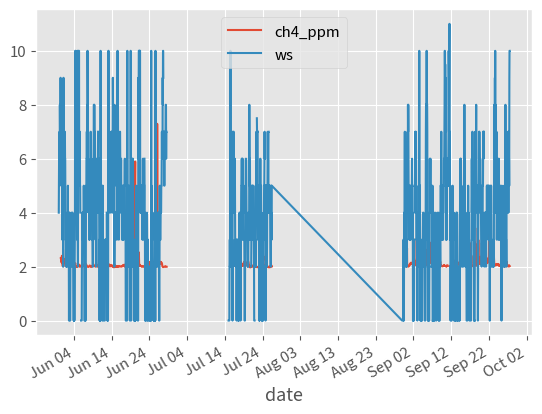

In [87]:
ax = df.plot(y=['ch4_ppm','ws'])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

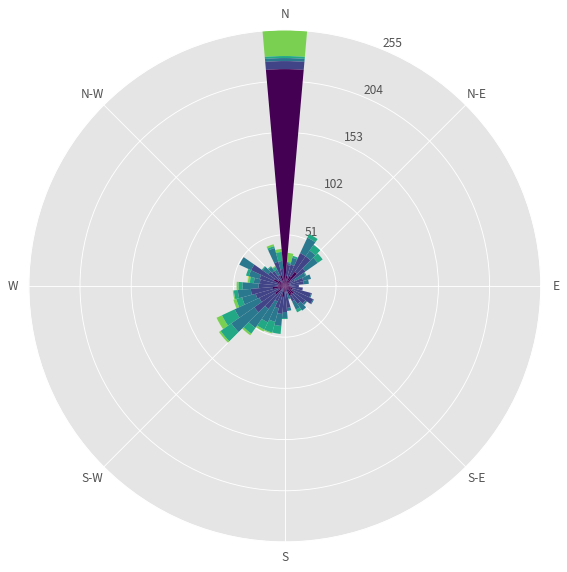

In [88]:
# ax = WindroseAxes.from_ax()
# ax.bar(df['wd'], df['ch4_ppb'], normed=False, opening=1,bins=np.arange(1900,2300,100),nsector=36,cmap=cm.Purples)
# for axis in [ax.get_xaxis(), ax.get_yaxis()]:
#     axis.set_zorder(-2000)
# plt.show()

ax = WindroseAxes.from_ax()
ax.bar(df['wd'], df['ws'], normed=False, opening=1,nsector=36,cmap=cm.viridis)
for axis in [ax.get_xaxis(), ax.get_yaxis()]:
    axis.set_zorder(-2000)
plt.show()

# ax= WindroseAxes.from_ax()
# wd = df['wd']
# ws = df['ch4_ppb'] 
# ax.contourf(wd, ws, cmap=cm.hot,bins=np.arange(1800,3000,100))
# for axis in [ax.get_xaxis(), ax.get_yaxis()]:
#     axis.set_zorder(-2000)
# ax.set_legend()

In [2]:
# from importlib import reload
# reload(maps)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from windrose import WindroseAxes

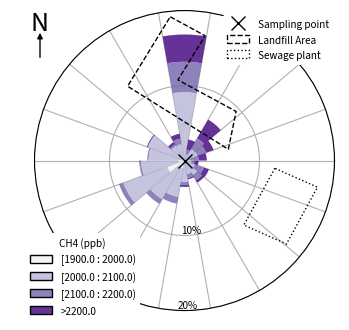

In [25]:
# Sources, lon and lat
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)
sampler = (0.144343, 52.237111)
plt.style.use("default")
rc('font',**{'family':'Source Sans 3','weight':'normal','size':'8'})
fig,ax = simple_map(landfill,sewage,sampler,drawmap=False)
sampler=ccrs.Mercator().transform_point(sampler[0],sampler[1],ccrs.PlateCarree())

ax.set_axis_off()
ax.set_zorder(100)

wrax = inset_axes(
    ax,
    width=3,  # size in inches
    height=3,  # size in inches
    loc="center",  # center bbox at given position
    axes_class= WindroseAxes,  # specify the class of the axe
    bbox_transform=ax.transData,
    bbox_to_anchor=(sampler[0],sampler[1])
)

leg = ax.legend(loc='upper right',bbox_to_anchor = (1,1),frameon=True,framealpha=1)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(1000000)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

mypurple = truncate_colormap(cm.Purples, 0.1, 1)

wrax.patch.set_alpha(0)
wrax.bar(df['wd'], df['ch4_ppb'], normed=True, opening=1,bins=np.arange(1900,2300,100),nsector=18,cmap=mypurple,alpha=0.8)
for axis in [wrax.get_xaxis(), wrax.get_yaxis()]:
     axis.set_zorder(-2000)

wrax.get_xaxis().set_ticks(np.radians(np.linspace(20,360,18)),labels=[])
wrax.get_yaxis().set_ticks([10,20],labels=["10%","20%"])
pos = wrax.get_rlabel_position()
wrax.set_rlabel_position(pos-160)
leg = wrax.legend(title='CH4 (ppb)',loc='lower left',bbox_to_anchor=(-0.05,-0.05),frameon=True,framealpha=1)
leg.set_zorder(10)
leg.get_frame().set_linewidth(0.0)

def add_north_arrow(ax):

  py =0.75 * ax.figure.bbox.height
  px =0.1 * ax.figure.bbox.width

  # Draw an arrow with a text "N" above it using annotation
  ax.annotate("N", xy=(px-9.5, py), fontsize=20, xycoords="figure pixels")
  ax.annotate("",  xy=(px,  py), xytext=(px, py-30),xycoords="figure pixels",
          arrowprops=dict(arrowstyle="-|>", facecolor="black"))

add_north_arrow(ax)
plt.savefig('windrose.png',dpi=300)



<GeoAxes: >

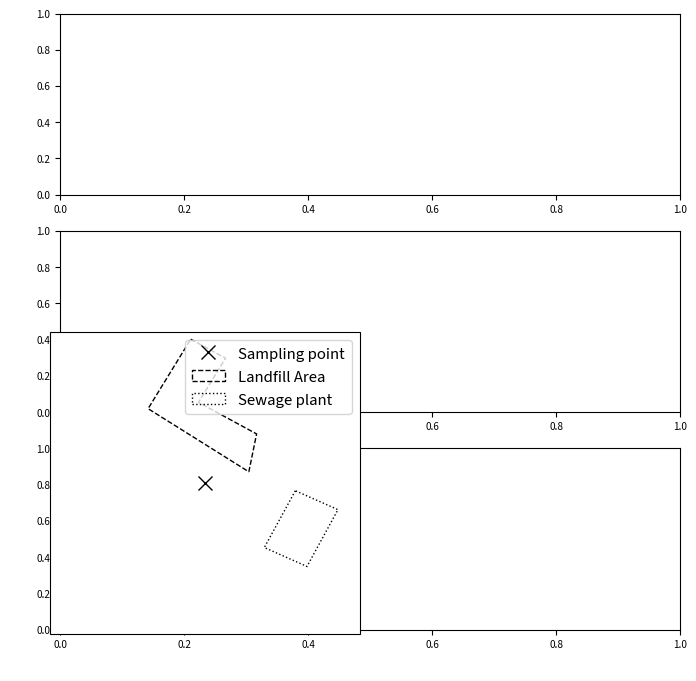

<Figure size 400x400 with 0 Axes>

In [91]:
# Draw big map with inset lower right windrose, underplots with wind speed, temperature
fig, axs = plt.subplots(3,1,figsize=(8,8),gridspec_kw={'height_ratios': [1,1,1]})

sampler = (0.144343, 52.237111)

mapfig, mapax = simple_map(landfill,sewage,sampler)
mapax.remove()

mapax.figure = fig
fig.axes.append(mapax)
fig.add_axes(mapax)


In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.patheffects import withStroke
from matplotlib.patches import Polygon
from geopy.distance import geodesic
import math
import numpy as np

# Refactored base map components
def simple_map(landfill_coords, sewage_coords, sample_coords,drawmap:bool=False):
    fig, ax = setup_map(sample_coords,drawmap=drawmap)
    plot_sampling_point(ax, sample_coords)
    plot_highlighted_polygons(ax)
    # plot_landfill_and_sewage_points(ax, landfill_coords, sewage_coords)
    # draw_distance_and_bearing(ax, landfill_coords, sample_coords)
    # draw_distance_and_bearing(ax, sewage_coords, sample_coords)
    add_gridlines_and_compass(ax)
    add_legend()
    
    return fig, ax

def setup_map(sample_coords, zoom_level=18,drawmap:bool=True):
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': ccrs.Mercator()})
    ax.set_extent([sample_coords[0] - 0.020, sample_coords[0] + 0.020,
                   sample_coords[1] - 0.012, sample_coords[1] + 0.012], crs=ccrs.PlateCarree())
    if drawmap:
        google_satellite = cimgt.GoogleTiles(style='street',cache=False)
        ax.add_image(google_satellite, zoom_level)
    return fig, ax

def plot_sampling_point(ax, sample_coords):
    ax.plot(sample_coords[0], sample_coords[1], marker='x', color='black', markersize=10, transform=ccrs.PlateCarree(), label='Sampling point',linestyle='None')
    # text = ax.text(sample_coords[0] + 0.001, sample_coords[1], "Sampling point", 
    #               transform=ccrs.PlateCarree(), fontsize=24, color='white', fontweight='bold')
    # text.set_path_effects([withStroke(linewidth=3, foreground='black')])

def plot_highlighted_polygons(ax):
    polygon_coords = [
        (0.1425, 52.2485), (0.1470, 52.2470), (0.1435, 52.2435),
        (0.1510, 52.2410), (0.1500, 52.2380), (0.1370, 52.2430)
    ]
    water_treatment_coords = [
        (0.1560, 52.2365), (0.1520, 52.2320), (0.1575, 52.2305), (0.1615, 52.2350)
    ]
    
    highlight_polygon = Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='none', linewidth=1,
                                linestyle='--', label='Landfill Area',transform=ccrs.PlateCarree())
    water_treatment_polygon = Polygon(water_treatment_coords, closed=True, edgecolor='black', facecolor='none',
                                      linewidth=1, linestyle='dotted', label='Sewage plant',transform=ccrs.PlateCarree())
    ax.add_patch(highlight_polygon)
    ax.add_patch(water_treatment_polygon)

def plot_landfill_and_sewage_points(ax, landfill_coords, sewage_coords):
    ax.plot(landfill_coords[0], landfill_coords[1], marker='*', color='red', markersize=40, markeredgewidth=2,
            markeredgecolor='black', transform=ccrs.PlateCarree(), label='Landfill source')
    ax.plot(sewage_coords[0], sewage_coords[1], marker='*', color='blue', markersize=40, markeredgewidth=2,
            markeredgecolor='black', transform=ccrs.PlateCarree(), label='Sewage source')

def calculate_initial_compass_bearing(pointA, pointB):
    lat1, lat2 = map(math.radians, [pointA[0], pointB[0]])
    diffLong = math.radians(pointB[1] - pointA[1])
    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(diffLong)
    initial_bearing = math.degrees(math.atan2(x, y))
    return (initial_bearing + 360) % 360

def draw_distance_and_bearing(ax, point1_coords, point2_coords):
    distance = geodesic((point1_coords[1], point1_coords[0]), (point2_coords[1], point2_coords[0])).km
    bearing = calculate_initial_compass_bearing((point1_coords[1], point1_coords[0]),
                                                (point2_coords[1], point2_coords[0]))
    ax.plot([point1_coords[0], point2_coords[0]], [point1_coords[1], point2_coords[1]],
            color='white', linestyle=':', linewidth=3, transform=ccrs.PlateCarree())
    ax.text((point1_coords[0] + point2_coords[0]) / 2, (point1_coords[1] + point2_coords[1]) / 2,
            f"{distance:.3f} km, {bearing:.1f}°", transform=ccrs.PlateCarree(), fontsize=16,
            color='white', fontweight='bold').set_path_effects([withStroke(linewidth=3, foreground='black')])

def add_gridlines_and_compass(ax):
    #gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.7, linestyle='--')

    # gl.xlabel_style = {'size': 15, 'color': 'black', 'weight': 'bold'}
    # gl.ylabel_style = {'size': 15, 'color': 'black', 'weight': 'bold'}
    
    # ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.85),
    #            arrowprops=dict(facecolor='white', edgecolor='black', linewidth=1, width=3, headwidth=5, headlength=2),
    #            ha='center', va='center', fontsize=30, color='white', xycoords='axes fraction',
    #            path_effects=[withStroke(linewidth=1, foreground='black')]
    #            )
    pass 

def add_legend():
    plt.legend(loc='upper right', fontsize=12)






# Function to add wind direction arrows
def add_wind_direction(ax, wind_angle):
    # Determine the wind vector components
    wind_angle_rad = np.deg2rad(wind_angle + 180)  # Adjust to reflect direction wind is coming from
    u = np.sin(wind_angle_rad)  # Eastward component
    v = np.cos(wind_angle_rad)  # Northward component

    # Get the current longitude and latitude range from the plot
    lon_min, lon_max = ax.get_xlim()
    lat_min, lat_max = ax.get_ylim()

    # Adjust the grid to ensure arrows do not plot near the edge
    buffer_lon = (lon_max - lon_min) * 0.1  # 10% buffer on longitude
    buffer_lat = (lat_max - lat_min) * 0.1  # 10% buffer on latitude
    lon_min += buffer_lon
    lon_max -= buffer_lon
    lat_min += buffer_lat
    lat_max -= buffer_lat

    # Generate a grid of points over the map for arrows
    x = np.linspace(lon_min, lon_max, 8)  # Longitude range divided into 8 points (slightly denser)
    y = np.linspace(lat_min, lat_max, 7)  # Latitude range divided into 7 points (increased density vertically)
    lons, lats = np.meshgrid(x, y)

    # Select every other arrow for plotting
    lons = lons[::2, ::2]
    lats = lats[::2, ::2]
    
    # Add arrows to the map with lighter teal color and thicker black outline
    ax.quiver(lons, lats, u, v, transform=ax.projection, color='#80cbc4', edgecolor='white', linewidth=2.0, scale=10, label='Wind direction')

    ax.legend(fontsize=20)
    
    return ax.figure, ax


# Function to add plume contours to an existing Cartopy figure
def add_plume_contours(fig, ax, lon, lat, concentration_data, x, y, z, z_height=10, levels=10, theta_deg=0):
    """
    Adds contours of concentration data to an existing figure.

    Parameters:
        fig: matplotlib Figure instance of the base map
        ax: cartopy GeoAxes instance to which the contours are added
        lon: float, Longitude of the Gaussian plume source
        lat: float, Latitude of the Gaussian plume source
        concentration_data: 3D numpy array, concentration data from the Gaussian plume model
        x, y, z: 1D numpy arrays, spatial coordinates corresponding to concentration_data
        z_height: float, height at which to extract concentration data for plotting (default 10 m)
        levels: List of contour levels to plot or integer for automatic levels (default 10)
        theta_deg: float, wind angle in degrees (default 0 degrees)
    """
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import LogLocator

    # Extract the concentration data at the specified height
    z_index = (np.abs(z - z_height)).argmin()
    concentration_at_height = concentration_data[:, :, z_index]

    min_value = 1e-15
    max_value = concentration_at_height.max()
    # Create logarithmic levels using np.logspace
    num_levels = 10  # Adjust this for more or fewer levels
    levels = np.logspace(np.log10(min_value), np.log10(max_value), num_levels)
    #concentration_at_height[concentration_at_height < 1e-15] = np.nan

    # Convert lon and lat to the projection's coordinate system
    proj = ccrs.TransverseMercator(central_longitude=lon, central_latitude=lat)
    origin_xy = proj.transform_point(lon, lat, ccrs.PlateCarree())

    # Shift and rotate the grid
    x_shifted = x[:, :, 0] + origin_xy[0]
    y_shifted = y[:, :, 0] + origin_xy[1]
    theta_deg = (theta_deg + 90)
    theta_deg = 360 - theta_deg   # Reverse the angle to match the wind direction

    theta = np.radians(theta_deg)  # Rotation angle in radians

    x_rotated = np.cos(theta) * x_shifted - np.sin(theta) * y_shifted
    y_rotated = np.sin(theta) * x_shifted + np.cos(theta) * y_shifted

    # Add filled contour plot of the concentration with transparency
    contour = ax.contourf(
        x_rotated, y_rotated, concentration_at_height,
        levels=levels, transform=proj, cmap='viridis', alpha=0.6, norm=LogNorm(vmin=min_value, vmax=max_value))

    ## Define a custom position for the colorbar that is 0.8 times the height of the plot with extra padding
    bbox = ax.get_position()
    cbar_ax = fig.add_axes([bbox.x1 + 0.1, bbox.y0 + 0.1, 0.02, 0.8 * (bbox.y1 - bbox.y0)])  # [left, bottom, width, height]
    
    # Create the colorbar using the defined position
    cbar = fig.colorbar(contour, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=18, width=2)  # Increase the font size and set bold tick labels
    cbar_ticks = [1e-15, 1e-13, 1e-11, 1e-9, 1e-7, 1e-5, 1e-3, max_value]  # Set ticks in range from 1e-15 to 1e-3
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{tick:.0e}" for tick in cbar_ticks])  # Use scientific notation labels

    cbar.ax.set_ylabel('Log Concentration (g/m^3)', fontsize=20, fontweight='bold')  # Increase the font size and make the label bold

    # Convert x_rotated and y_rotated back to lon/lat in PlateCarree projection using the ax projection
    lonlat_coords = ax.projection.transform_points(proj, x_rotated, y_rotated)

    # Extract longitude and latitude
    plume_lons = lonlat_coords[:, :, 0]
    plume_lats = lonlat_coords[:, :, 1]
    plume_data = (plume_lons, plume_lats, concentration_at_height)


    return fig, ax, plume_data


/tmp/ipykernel_131584/22175752.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


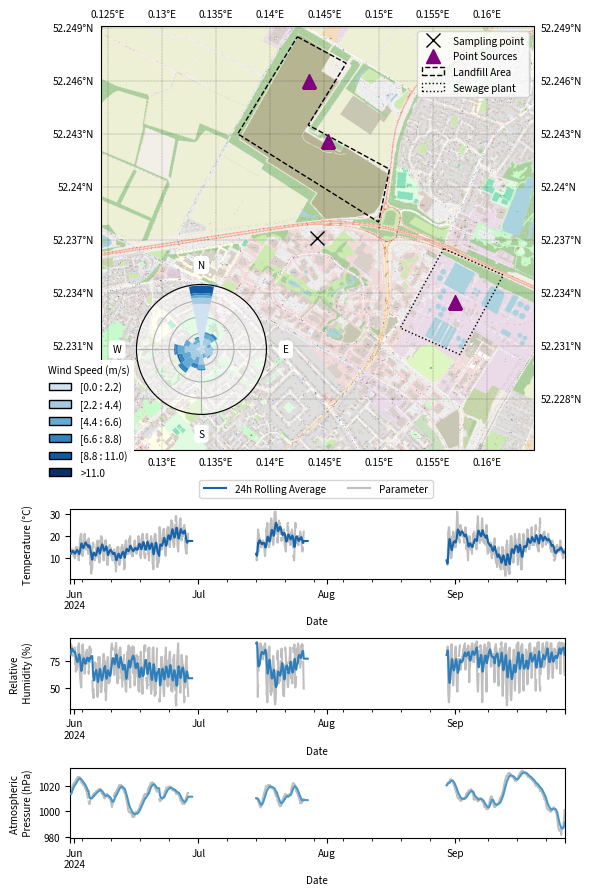

In [52]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import brokenaxes as bax
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from windrose import WindroseAxes
from matplotlib import cm
from matplotlib.patheffects import withStroke

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [6, 1, 1, 1]})

# Plot the large map in the first subplot
sampler = (0.144343, 52.237111)
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)
lfgsource = (0.1453,  52.24259)

# Setup map
axs[0].set_axis_off()

mapax = fig.add_subplot(4, 1, 1, projection=ccrs.Mercator())
mapax.set_extent([sampler[0] - 0.020, sampler[0] + 0.020, sampler[1] - 0.012, sampler[1] + 0.012], crs=ccrs.PlateCarree())
tilemap = cimgt.OSM(cache=True)
# tilemap = cimgt.GoogleTiles(style='satellite', cache=False)
mapax.add_image(tilemap, 18)
#Plot sampling point
mapax.plot(sampler[0], sampler[1], marker='x', color='black', markersize=10, transform=ccrs.PlateCarree(), label='Sampling point',linestyle='None')
mapax.plot(lfgsource[0], lfgsource[1], marker='^', color='purple', markersize=10, transform=ccrs.PlateCarree())
# Plot landfill and sewage points
mapax.plot([sewage[0],landfill[0]], [sewage[1],landfill[1]], marker='^', color='purple', markersize=10, transform=ccrs.PlateCarree(), label='Point Sources',linestyle='None')
# Plot highlighted polygons
polygon_coords = [
    (0.1425, 52.2485), (0.1470, 52.2470), (0.1435, 52.2435),
    (0.1510, 52.2410), (0.1500, 52.2380), (0.1370, 52.2430)
]
water_treatment_coords = [
    (0.1560, 52.2365), (0.1520, 52.2320), (0.1575, 52.2305), (0.1615, 52.2350)
]

highlight_polygon = Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='none', linewidth=1,
                            linestyle='--', label='Landfill Area', transform=ccrs.PlateCarree())
water_treatment_polygon = Polygon(water_treatment_coords, closed=True, edgecolor='black', facecolor='none',
                                  linewidth=1, linestyle='dotted', label='Sewage plant', transform=ccrs.PlateCarree())
mapax.add_patch(highlight_polygon)
mapax.add_patch(water_treatment_polygon)
gl = mapax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.2, color='black', alpha=0.7, linestyle='--')

ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.85),
            arrowprops=dict(facecolor='white', edgecolor='black', linewidth=1, width=3, headwidth=5, headlength=2),
            ha='center', va='center', fontsize=30, color='white', xycoords='axes fraction',
            path_effects=[withStroke(linewidth=1, foreground='black')]
            )
# Add legend
mapax.legend(loc='upper right')
dffiltered = df.copy()
dffiltered['ALTM_hPa'] = dffiltered['ALTM_hPa'][dffiltered['ALTM_hPa'] > 100]  # Remove negative pressure values
dffiltered['rh'] = dffiltered['rh'][(dffiltered['rh'] < 100) & (dffiltered['rh']>10)]  # Remove relative humidity values above 100%
dffiltered = dffiltered.resample('1h').mean()
df1 = dffiltered
df1['temp_rolling'] = df1['temp'].ewm(span=24).mean()
df1['rh_rolling'] = df1['rh'].ewm(span=24).mean()
df1['ALTM_hPa_rolling'] = df1['ALTM_hPa'].ewm(span=24).mean()

# Remove data from the rolling averages where the last 24 points were NaN
df1['temp_rolling'] = df1['temp_rolling'].where(df1['temp'].rolling(window=24, min_periods=1).count()!=0)
df1['rh_rolling'] = df1['rh_rolling'].where(df1['rh'].rolling(window=24, min_periods=1).count()!=0)
df1['ALTM_hPa_rolling'] = df1['ALTM_hPa_rolling'].where(df1['ALTM_hPa'].rolling(window=24, min_periods=1).count()!=0)


df1[['temp_rolling']].plot(ax=axs[1], color=cm.Blues(0.8), legend=False,zorder=10)
df1[['rh_rolling']].plot(ax=axs[2], color=cm.Blues(0.7), legend=False,zorder=10)
df1[['ALTM_hPa_rolling']].plot(ax=axs[3], color=cm.Blues(0.6), legend=False,zorder=10)

# Plot the actual data on each subplot in grey
df1[['temp']].plot(ax=axs[1], color='grey', legend=False,alpha=0.5)
df1[['rh']].plot(ax=axs[2], color='grey', legend=False,alpha=0.5)
df1[['ALTM_hPa']].plot(ax=axs[3], color='grey', legend=False,alpha=0.5)

# Add a single legend for all subplots
lines_labels = [axs[1].get_legend_handles_labels(), axs[2].get_legend_handles_labels(), axs[3].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, [ '24h Rolling Average','Parameter'], loc='upper center',bbox_to_anchor=(0.53,0.47),ncol=3)
# Plot the time series of meteorological parameters in the remaining subplots
axs[1].set_ylabel('Temperature (°C)')
axs[1].set_xlabel('Date')

axs[2].set_ylabel('Relative \n Humidity (%)')
axs[2].set_xlabel('Date')



axs[3].set_ylabel('Atmospheric \n Pressure (hPa)')
axs[3].set_xlabel('Date')

# Add an inset wind rose in the bottom left of the first subplot
wrax = inset_axes(
    mapax,
    width=1.3,  # size in inches
    height=1.3,  # size in inches
    loc="lower left",  # position
    axes_class=WindroseAxes,  # specify the class of the axe
    bbox_transform=mapax.transAxes,
    bbox_to_anchor=(0.07, 0.07)
)

blueshort = truncate_colormap(cm.Blues,0.2,1)

wrax.bar(df['wd'], df['ws'], normed=True, opening=1, nsector=16, cmap=blueshort, alpha=1,zorder=100)
wrax.set_legend()
wrax.legend(title='Wind Speed (m/s)', loc='upper left', bbox_to_anchor=(-0.76, 0.46), frameon=True, framealpha=1)
wrax.get_legend().get_frame().set_linewidth(0.0)

bbox = dict(boxstyle="round", ec="white", fc="white", alpha=1)
plt.setp(wrax.get_xticklabels(), bbox=bbox)

wrax.get_xaxis().set_ticks(np.radians([90,180,270,360]),labels=["N","W","S","E"])
wrax.get_yaxis().set_ticks([5,10,15,20],labels=["","","",""])
for axis in [wrax.get_xaxis(), wrax.get_yaxis()]:
    axis.set_zorder(-2000)
wrax.patch.set_alpha(0.5)
# Adjust layout
plt.tight_layout()

wrax.set_rlabel_position(pos-150)

fig.align_ylabels(axs)
# Save the figure
plt.savefig('map_and_meteorological_parameters.png', dpi=300)
plt.show()

/tmp/ipykernel_90750/1140493006.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


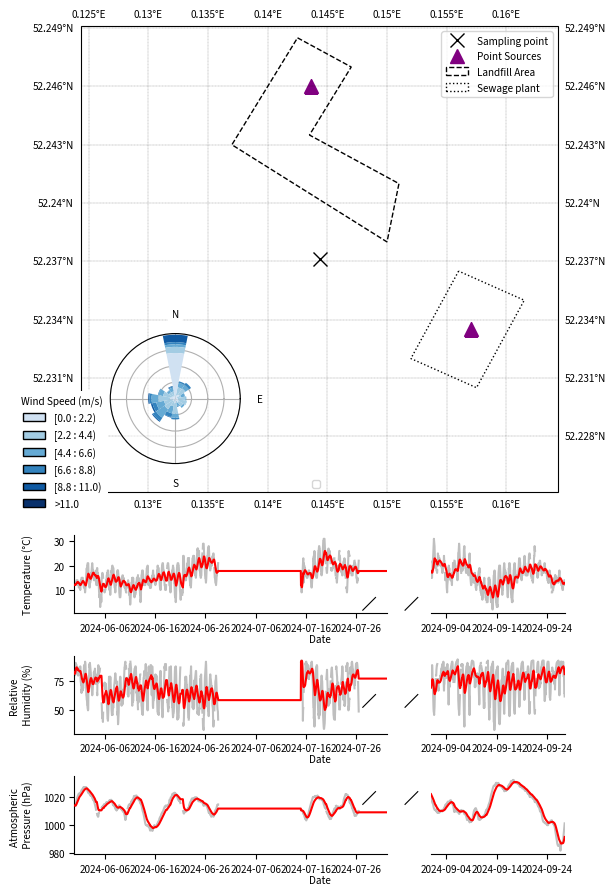

In [ ]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import brokenaxes as bax
from brokenaxes import brokenaxes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure with a gridspec layout
fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(4, 1, height_ratios=[6, 1, 1, 1])

# Create broken axes for the time series plots
bax_temp = brokenaxes(xlims=((pd.Timestamp(df1.index.min()), pd.Timestamp('2024-07-31 23:59:59')), (pd.Timestamp('2024-09-01 00:00:00'), pd.Timestamp(df1.index.max()))), subplot_spec=gs[1])
bax_rh = brokenaxes(xlims=((pd.Timestamp(df1.index.min()), pd.Timestamp('2024-07-31 23:59:59')), (pd.Timestamp('2024-09-01 00:00:00'), pd.Timestamp(df1.index.max()))), subplot_spec=gs[2])
bax_altm = brokenaxes(xlims=((pd.Timestamp(df1.index.min()), pd.Timestamp('2024-07-31 23:59:59')), (pd.Timestamp('2024-09-01 00:00:00'), pd.Timestamp(df1.index.max()))), subplot_spec=gs[3])

# Plot the large map in the first subplot
sampler = (0.144343, 52.237111)
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)


# Setup map

mapax = fig.add_subplot(4, 1, 1, projection=ccrs.Mercator())
mapax.set_extent([sampler[0] - 0.020, sampler[0] + 0.020, sampler[1] - 0.012, sampler[1] + 0.012], crs=ccrs.PlateCarree())
#tilemap = cimgt.OSM(cache=True)
# tilemap = cimgt.GoogleTiles(style='satellite', cache=False)
# mapax.add_image(tilemap, 18)
#Plot sampling point
mapax.plot(sampler[0], sampler[1], marker='x', color='black', markersize=10, transform=ccrs.PlateCarree(), label='Sampling point',linestyle='None')

# Plot landfill and sewage points
mapax.plot([sewage[0],landfill[0]], [sewage[1],landfill[1]], marker='^', color='purple', markersize=10, transform=ccrs.PlateCarree(), label='Point Sources',linestyle='None')
# Plot highlighted polygons
polygon_coords = [
    (0.1425, 52.2485), (0.1470, 52.2470), (0.1435, 52.2435),
    (0.1510, 52.2410), (0.1500, 52.2380), (0.1370, 52.2430)
]
water_treatment_coords = [
    (0.1560, 52.2365), (0.1520, 52.2320), (0.1575, 52.2305), (0.1615, 52.2350)
]

highlight_polygon = Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='none', linewidth=1,
                            linestyle='--', label='Landfill Area', transform=ccrs.PlateCarree())
water_treatment_polygon = Polygon(water_treatment_coords, closed=True, edgecolor='black', facecolor='none',
                                  linewidth=1, linestyle='dotted', label='Sewage plant', transform=ccrs.PlateCarree())
mapax.add_patch(highlight_polygon)
mapax.add_patch(water_treatment_polygon)
gl = mapax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.2, color='black', alpha=0.7, linestyle='--')

ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.85),
            arrowprops=dict(facecolor='white', edgecolor='black', linewidth=1, width=3, headwidth=5, headlength=2),
            ha='center', va='center', fontsize=30, color='white', xycoords='axes fraction',
            path_effects=[withStroke(linewidth=1, foreground='black')]
            )
# Add legend
mapax.legend(loc='upper right')
dffiltered = df.copy()
dffiltered['ALTM_hPa'] = dffiltered['ALTM_hPa'][dffiltered['ALTM_hPa'] > 100]  # Remove negative pressure values
dffiltered['rh'] = dffiltered['rh'][(dffiltered['rh'] < 100) & (dffiltered['rh']>10)]  # Remove relative humidity values above 100%
dffiltered = dffiltered.resample('1h').mean()
df1 = dffiltered



# Calculate rolling daily average
df1['temp_rolling'] = df1['temp'].ewm(span=24).mean()
df1['rh_rolling'] = df1['rh'].ewm(span=24).mean()
df1['ALTM_hPa_rolling'] = df1['ALTM_hPa'].ewm(span=24).mean()


# Plot the rolling averages on broken axes
bax_temp.plot(df1.index, df1['temp_rolling'], color='red', label='Rolling Average', zorder=10)
bax_rh.plot(df1.index, df1['rh_rolling'], color='red', label='Rolling Average', zorder=10)
bax_altm.plot(df1.index, df1['ALTM_hPa_rolling'], color='red', label='Rolling Average', zorder=10)

# Plot the actual data on each broken axes in grey
bax_temp.plot(df1.index, df1['temp'], color='grey', alpha=0.5, label='Actual Data')
bax_rh.plot(df1.index, df1['rh'], color='grey', alpha=0.5, label='Actual Data')
bax_altm.plot(df1.index, df1['ALTM_hPa'], color='grey', alpha=0.5, label='Actual Data')

# Add a single legend for all subplots
fig.legend([], ['Rolling Average', 'Actual Data'], loc='upper center', bbox_to_anchor=(0.53, 0.47), ncol=3)

# Plot the time series of meteorological parameters in the remaining subplots
bax_temp.set_ylabel('Temperature (°C)')
bax_temp.set_xlabel('Date')

bax_rh.set_ylabel('Relative \n Humidity (%)')
bax_rh.set_xlabel('Date')

bax_altm.set_ylabel('Atmospheric \n Pressure (hPa)')
bax_altm.set_xlabel('Date')

# Add an inset wind rose in the bottom left of the first subplot
wrax = inset_axes(
    mapax,
    width=1.3,  # size in inches
    height=1.3,  # size in inches
    loc="lower left",  # position
    axes_class=WindroseAxes,  # specify the class of the axe
    bbox_transform=mapax.transAxes,
    bbox_to_anchor=(0.05, 0.05)
)

blueshort = truncate_colormap(cm.Blues,0.2,1)

wrax.bar(df['wd'], df['ws'], normed=True, opening=1, nsector=16, cmap=blueshort, alpha=1,zorder=100)
wrax.set_legend()
wrax.legend(title='Wind Speed (m/s)', loc='upper left', bbox_to_anchor=(-0.76, 0.6), frameon=True, framealpha=1)
wrax.get_legend().get_frame().set_linewidth(0.0)

bbox = dict(boxstyle="round", ec="white", fc="white", alpha=1)
plt.setp(wrax.get_xticklabels(), bbox=bbox)

wrax.get_xaxis().set_ticks(np.radians([90,180,270,360]),labels=["N","W","S","E"])
wrax.get_yaxis().set_ticks([5,10,15,20],labels=["","","",""])
for axis in [wrax.get_xaxis(), wrax.get_yaxis()]:
    axis.set_zorder(-2000)
wrax.patch.set_alpha(0.5)
# Adjust layout
plt.tight_layout()

wrax.set_rlabel_position(pos-150)

fig.align_ylabels(axs)
# Save the figure
plt.savefig('map_and_meteorological_parameters.png', dpi=300)
plt.show()

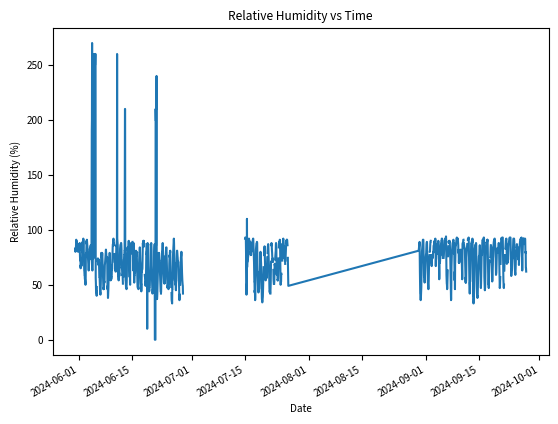

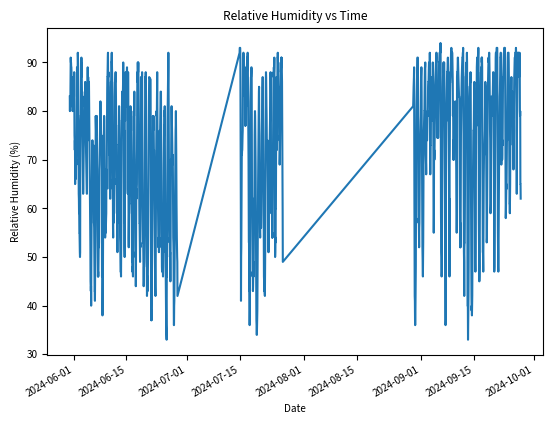

In [107]:
df['rh'].plot()
plt.xlabel('Date')
plt.ylabel('Relative Humidity (%)')
plt.title('Relative Humidity vs Time')
plt.show()
# Filter out super high values of relative humidity
df_filtered = df[(df['rh'] < 100) & (df['rh'] > 10)]
df_filtered['rh'].plot()
plt.xlabel('Date')
plt.ylabel('Relative Humidity (%)')
plt.title('Relative Humidity vs Time')
plt.show()

/tmp/ipykernel_131584/2399265231.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


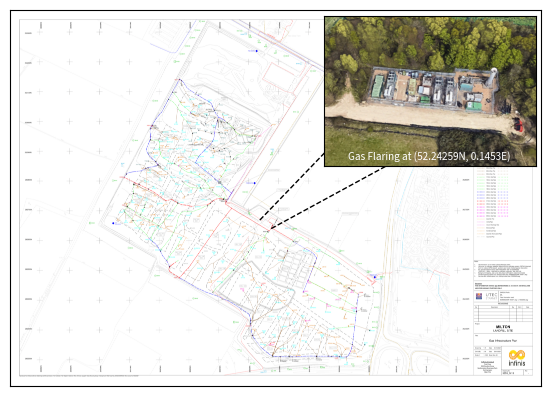

In [50]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the main image
img = mpimg.imread('basemap.png')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Display the main image
ax.imshow(img)

# Create an inset axis for the zoomed-in image
ax_inset = inset_axes(ax, width="40%", height="40%", loc='upper right')

# Load the zoomed-in image
img_zoom = mpimg.imread('site.png')

# Display the zoomed-in image in the inset axis
ax_inset.imshow(img_zoom)

# Remove axis ticks and labels from the inset axis
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
# Add text to the bottom of the inset axis
ax_inset.text(0.5, 0.1, 'Gas Flaring at (52.24259N, 0.1453E)', transform=ax_inset.transAxes, ha='center', va='top', fontsize=8, color='white')

# Draw lines to indicate the zoom-in area
x1, x2, y1, y2 = 4600,8000,3850,2000  # Coordinates for the zoom-in area in the main image
ax.plot([x1,x2], [y1, y2], color='black', linestyle='--', linewidth=1,zorder=1000)
x3, x4, y3, y4 = 4400, 7000, 3700, 1000  # Coordinates for the zoom-in area in the zoomed-in image
ax.plot([x3,x4], [y3, y4], color='black', linestyle='--', linewidth=1,zorder=1000)
# Save the figure
plt.tight_layout()
plt.savefig('zoomed_map.png', dpi=1000)
plt.show()